In [1]:
#Mounting Google Drive from Google Colab
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#Changing the current working directory to the Google Drive
#%cd /content/drive/My Drive/MLDL2024_project1-Enrico

In [3]:
#!pip install -U fvcore

In [4]:
#Importing the necessary libraries
import os
import torch
import numpy as np
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets.cityscapes import CityscapesCustom
from datasets.gta5 import GTA5Custom
from models.deeplabv2.deeplabv2 import get_deeplab_v2
from models.bisenet.build_bisenet import BiSeNet
from train import train_model
from utils import test_latency_FPS, test_FLOPs_params, plot_miou_over_epochs

In [5]:
#Set device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Set the manual seeds
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

#Set training parameters
cityscapes_height, cityscapes_width = (32, 64)
gta5_height, gta5_width = (32, 64)
train_batch_size = 4
n_epochs = 10

class_names = ["road", "sidewalk", "building", "wall", "fence", "pole", "traffic_light", "traffic_sign",
                "vegetation", "terrain", "sky", "person", "rider", "car", "truck", "bus", "train",
                "motorcycle", "bicycle"
]

In [6]:
#Create Dataloaders for Cityscapes
cityscapes_dir = os.path.dirname(os.getcwd()) + '/Cityscapes/Cityspaces/'

cityscapes_train_dataset = CityscapesCustom(cityscapes_dir, 'train', cityscapes_height, cityscapes_width)
cityscapes_test_dataset = CityscapesCustom(cityscapes_dir, 'val', cityscapes_height, cityscapes_width)

cityscapes_train_dataloader = DataLoader(cityscapes_train_dataset, train_batch_size, shuffle=True)
cityscapes_test_dataloader = DataLoader(cityscapes_test_dataset, train_batch_size, shuffle=False)

print(f'Train: {len(cityscapes_train_dataset)} images, divided into {len(cityscapes_train_dataloader)} batches of size {cityscapes_train_dataloader.batch_size}')
print(f'Test: {len(cityscapes_test_dataset)} images, divided into {len(cityscapes_test_dataloader)} batches of size {cityscapes_test_dataloader.batch_size}')

Train: 1572 images, divided into 393 batches of size 4
Test: 500 images, divided into 125 batches of size 4


In [7]:
#Create Dataloader for GTA5
gta5_dir = os.path.dirname(os.getcwd()) + '/GTA5/GTA5/'

gta5_dataset = GTA5Custom(gta5_dir, gta5_height, gta5_width)

gta5_dataloader = DataLoader(gta5_dataset, train_batch_size, shuffle=True)

print(f'GTA5: {len(gta5_dataset)} images, divided into {len(gta5_dataloader)} batches of size {gta5_dataloader.batch_size}')

GTA5: 2500 images, divided into 625 batches of size 4


Deeplab pretraining loading...


Epoch 1/10  54s]
Train mIoU: 16.18%, Test mIoU: 19.02%
road: 82.83% sidewalk: 29.21% building: 59.98% wall: 0.00% fence: 2.07% pole: 0.01% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 60.75% terrain: 16.14% sky: 56.64% person: 7.19% rider: 0.00% car: 46.53% truck: 0.04% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 2/10  2s]
Train mIoU: 19.66%, Test mIoU: 20.39%
road: 85.69% sidewalk: 29.18% building: 62.72% wall: 0.14% fence: 2.11% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 61.34% terrain: 24.40% sky: 61.70% person: 10.73% rider: 0.00% car: 49.37% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 3/10  11s]
Train mIoU: 21.17%, Test mIoU: 19.81%
road: 85.81% sidewalk: 31.14% building: 61.16% wall: 0.26% fence: 0.01% pole: 0.03% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 57.97% terrain: 15.60% sky: 59.06% person: 14.94% rider: 0.00% car: 50.40% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 4/10  11s]
Train mIoU: 22.92%, Test mIoU: 21.06%
road: 85.54% sidewalk: 33.26% building: 62.77% wall: 1.39% fence: 2.55% pole: 0.01% traffic_light: 0.00% traffic_sign: 0.02% vegetation: 61.79% terrain: 17.60% sky: 60.27% person: 17.66% rider: 0.00% car: 52.88% truck: 4.35% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 5/10  5s]
Train mIoU: 24.26%, Test mIoU: 21.29%
road: 86.64% sidewalk: 32.78% building: 63.43% wall: 8.00% fence: 0.49% pole: 0.01% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 63.31% terrain: 21.91% sky: 61.60% person: 4.09% rider: 0.00% car: 52.97% truck: 6.12% bus: 0.00% train: 3.10% motorcycle: 0.00% bicycle: 0.00% 

Epoch 6/10  52s]
Train mIoU: 25.99%, Test mIoU: 21.16%
road: 85.46% sidewalk: 35.35% building: 62.12% wall: 2.07% fence: 1.05% pole: 0.03% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 61.83% terrain: 21.64% sky: 61.38% person: 16.18% rider: 0.00% car: 52.18% truck: 0.04% bus: 1.56% train: 0.36% motorcycle: 0.41% bicycle: 0.35% 

Epoch 7/10  7s]
Train mIoU: 28.01%, Test mIoU: 22.28%
road: 87.30% sidewalk: 36.18% building: 63.98% wall: 10.38% fence: 5.01% pole: 0.01% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 62.33% terrain: 23.97% sky: 60.04% person: 13.28% rider: 0.00% car: 54.59% truck: 4.46% bus: 0.92% train: 0.69% motorcycle: 0.00% bicycle: 0.15% 

Epoch 8/10  30s]
Train mIoU: 22.54%, Test mIoU: 19.95%
road: 84.83% sidewalk: 25.19% building: 62.01% wall: 3.72% fence: 0.73% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 61.91% terrain: 20.34% sky: 59.04% person: 11.36% rider: 0.00% car: 49.99% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 9/10  24s]
Train mIoU: 23.68%, Test mIoU: 21.59%
road: 86.37% sidewalk: 36.99% building: 64.05% wall: 8.73% fence: 2.49% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 63.60% terrain: 22.19% sky: 61.42% person: 8.67% rider: 0.00% car: 52.80% truck: 1.78% bus: 1.00% train: 0.09% motorcycle: 0.00% bicycle: 0.00% 

Epoch 10/10  24s]
Train mIoU: 28.12%, Test mIoU: 21.60%
road: 86.91% sidewalk: 36.35% building: 62.07% wall: 6.03% fence: 3.29% pole: 0.06% traffic_light: 0.00% traffic_sign: 0.32% vegetation: 61.53% terrain: 25.30% sky: 61.95% person: 12.36% rider: 0.00% car: 53.08% truck: 0.04% bus: 0.64% train: 0.26% motorcycle: 0.00% bicycle: 0.23% 
Best IoU: 22.28% at epoch 7
road: 87.30% sidewalk: 36.18% building: 63.98% wall: 10.38% fence: 5.01% pole: 0.01% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 62.33% terrain: 23.97% sky: 60.04% person: 13.28% rider: 0.00% car: 54.59% truck: 4.46% bus: 0.92% train: 0.69% motorcycle: 0.00% bicycle: 0.15% 

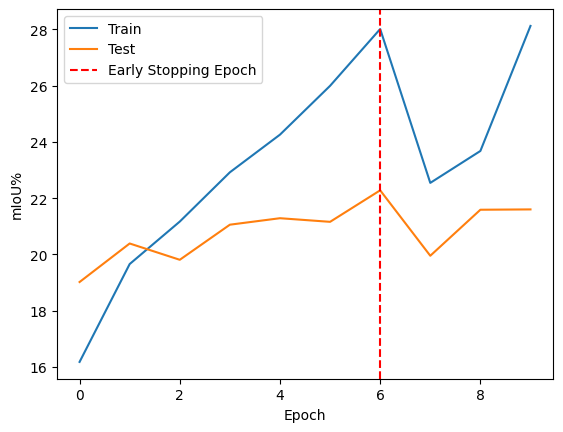

In [8]:
#Testing Classic semantic segmentation network

#Set up the model with the pretrained weights
DeepLabV2_model = get_deeplab_v2().to(device)

#Set up the loss function and the optimizer
DeepLabV2_criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
DeepLabV2_optimizer = optim.Adam(DeepLabV2_model.parameters(), lr=1e-3)

#Test latency and FPS
#print(test_latency_FPS(DeepLabV2_model, device, cityscapes_height, cityscapes_width))

#Test FLOPs and number of parameters
#print(test_FLOPs_params(DeepLabV2_model, device, cityscapes_height, cityscapes_width))

#Train the model
all_train_miou, all_test_miou, best_epoch = train_model(DeepLabV2_model, DeepLabV2_criterion, DeepLabV2_optimizer,
            cityscapes_train_dataloader, cityscapes_test_dataloader, class_names, device, n_epochs,
            lr_schedule=False, model_name='DeepLabV2')

plot_miou_over_epochs(all_train_miou, all_test_miou, best_epoch)

Epoch 1/10  31s]
Train mIoU: 11.92%, Test mIoU: 14.20%
road: 80.60% sidewalk: 19.41% building: 51.01% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 55.08% terrain: 1.17% sky: 47.53% person: 0.00% rider: 0.00% car: 14.90% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 2/10  50s]
Train mIoU: 15.45%, Test mIoU: 15.15%
road: 79.14% sidewalk: 19.62% building: 48.84% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 50.92% terrain: 9.52% sky: 54.05% person: 0.00% rider: 0.00% car: 25.84% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 3/10  51s]
Train mIoU: 17.05%, Test mIoU: 14.31%
road: 81.68% sidewalk: 16.50% building: 51.73% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 34.99% terrain: 2.52% sky: 52.46% person: 0.00% rider: 0.00% car: 32.02% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 4/10  49s]
Train mIoU: 18.04%, Test mIoU: 16.05%
road: 83.04% sidewalk: 18.46% building: 52.94% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 43.36% terrain: 11.58% sky: 54.43% person: 0.00% rider: 0.00% car: 41.18% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 5/10  53s]
Train mIoU: 18.82%, Test mIoU: 17.74%
road: 83.60% sidewalk: 23.72% building: 58.01% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 58.53% terrain: 18.20% sky: 52.01% person: 0.00% rider: 0.00% car: 43.03% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 6/10  54s]
Train mIoU: 19.34%, Test mIoU: 18.35%
road: 83.76% sidewalk: 21.05% building: 59.87% wall: 0.00% fence: 0.29% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 60.41% terrain: 20.54% sky: 57.97% person: 0.00% rider: 0.00% car: 44.82% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 7/10  50s]
Train mIoU: 19.79%, Test mIoU: 18.58%
road: 83.76% sidewalk: 24.51% building: 60.18% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 60.51% terrain: 19.16% sky: 59.55% person: 0.09% rider: 0.00% car: 45.20% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 8/10  51s]
Train mIoU: 20.31%, Test mIoU: 18.56%
road: 83.63% sidewalk: 23.95% building: 60.56% wall: 0.11% fence: 0.24% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 60.01% terrain: 21.79% sky: 54.58% person: 1.06% rider: 0.00% car: 46.74% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 9/10  50s]
Train mIoU: 20.88%, Test mIoU: 18.82%
road: 83.79% sidewalk: 26.01% building: 61.39% wall: 0.25% fence: 0.17% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 61.13% terrain: 16.96% sky: 59.48% person: 1.12% rider: 0.00% car: 47.27% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 10/10  45s]
Train mIoU: 21.32%, Test mIoU: 18.74%
road: 83.64% sidewalk: 26.47% building: 60.23% wall: 0.53% fence: 0.24% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 58.28% terrain: 19.20% sky: 58.31% person: 1.52% rider: 0.00% car: 47.56% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 
Best IoU: 18.82% at epoch 9
road: 83.79% sidewalk: 26.01% building: 61.39% wall: 0.25% fence: 0.17% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 61.13% terrain: 16.96% sky: 59.48% person: 1.12% rider: 0.00% car: 47.27% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

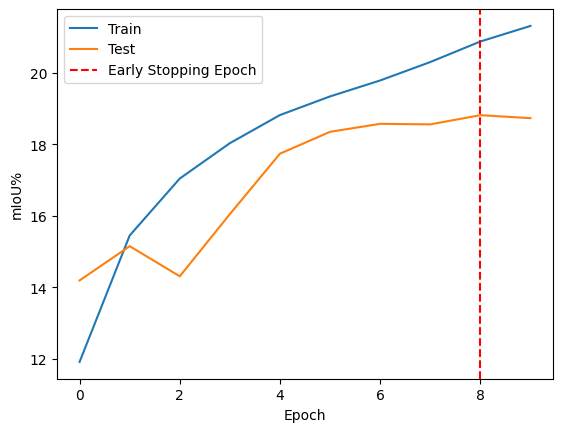

In [9]:
#Testing Real-Time semantic segmentation network

#Set up the model with the pretrained weights
BiSeNet_model = BiSeNet(num_classes=19, context_path='resnet18').to(device)

#Set up the loss function and the optimizer for BiSeNet
BiSeNet_criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
BiSeNet_optimizer = torch.optim.SGD(BiSeNet_model.parameters(), lr=2.5e-2, momentum=0.9, weight_decay=1e-4)

#Test latency and FPS
#print(test_latency_FPS(BiSeNet_model, device, cityscapes_height, cityscapes_width))

#Test FLOPs and number of parameters
#print(test_FLOPs_params(BiSeNet_model, device, cityscapes_height, cityscapes_width))

#Train the model
all_train_miou, all_test_miou, best_epoch = train_model(BiSeNet_model, BiSeNet_criterion, BiSeNet_optimizer,
            cityscapes_train_dataloader, cityscapes_test_dataloader, class_names, device, n_epochs,
            lr_schedule=True, model_name='BiSeNet')

plot_miou_over_epochs(all_train_miou, all_test_miou, best_epoch)

Epoch 1/10  26s]
Train mIoU: 10.16%, Test mIoU: 8.68%
road: 73.74% sidewalk: 0.90% building: 41.01% wall: 0.42% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 0.00% terrain: 0.00% sky: 33.11% person: 0.00% rider: 0.00% car: 15.75% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 2/10  29s]
Train mIoU: 12.83%, Test mIoU: 11.87%
road: 77.86% sidewalk: 4.74% building: 43.54% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 35.61% terrain: 5.16% sky: 44.15% person: 0.00% rider: 0.00% car: 14.42% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 3/10  25s]
Train mIoU: 15.25%, Test mIoU: 6.32%
road: 38.98% sidewalk: 1.10% building: 1.03% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 35.06% terrain: 1.92% sky: 41.69% person: 0.00% rider: 0.00% car: 0.35% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 4/10  18s]
Train mIoU: 16.59%, Test mIoU: 9.01%
road: 70.36% sidewalk: 1.14% building: 6.66% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 39.40% terrain: 2.78% sky: 43.47% person: 0.00% rider: 0.00% car: 7.46% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 5/10  59s]
Train mIoU: 17.90%, Test mIoU: 10.01%
road: 77.18% sidewalk: 2.53% building: 11.96% wall: 0.01% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 39.83% terrain: 2.70% sky: 44.86% person: 0.00% rider: 0.00% car: 11.05% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 6/10  0s]
Train mIoU: 19.41%, Test mIoU: 9.99%
road: 78.38% sidewalk: 1.90% building: 10.01% wall: 0.18% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 38.59% terrain: 3.72% sky: 43.03% person: 0.00% rider: 0.00% car: 13.91% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 7/10  1s]
Train mIoU: 20.96%, Test mIoU: 9.14%
road: 63.95% sidewalk: 1.25% building: 11.05% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 38.55% terrain: 2.72% sky: 42.89% person: 0.00% rider: 0.00% car: 12.71% truck: 0.47% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 8/10  16s]
Train mIoU: 22.36%, Test mIoU: 9.95%
road: 69.96% sidewalk: 2.23% building: 14.31% wall: 0.20% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 40.24% terrain: 3.03% sky: 42.58% person: 0.00% rider: 0.00% car: 15.90% truck: 0.64% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 9/10  1s]
Train mIoU: 23.34%, Test mIoU: 9.24%
road: 73.02% sidewalk: 1.84% building: 11.40% wall: 0.33% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 37.52% terrain: 2.50% sky: 40.36% person: 0.00% rider: 0.00% car: 8.03% truck: 0.57% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

Epoch 10/10  8s]
Train mIoU: 24.40%, Test mIoU: 10.53%
road: 77.22% sidewalk: 2.05% building: 15.29% wall: 0.55% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 40.02% terrain: 2.93% sky: 42.91% person: 0.00% rider: 0.00% car: 18.35% truck: 0.78% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 
Best IoU: 11.87% at epoch 2
road: 77.86% sidewalk: 4.74% building: 43.54% wall: 0.00% fence: 0.00% pole: 0.00% traffic_light: 0.00% traffic_sign: 0.00% vegetation: 35.61% terrain: 5.16% sky: 44.15% person: 0.00% rider: 0.00% car: 14.42% truck: 0.00% bus: 0.00% train: 0.00% motorcycle: 0.00% bicycle: 0.00% 

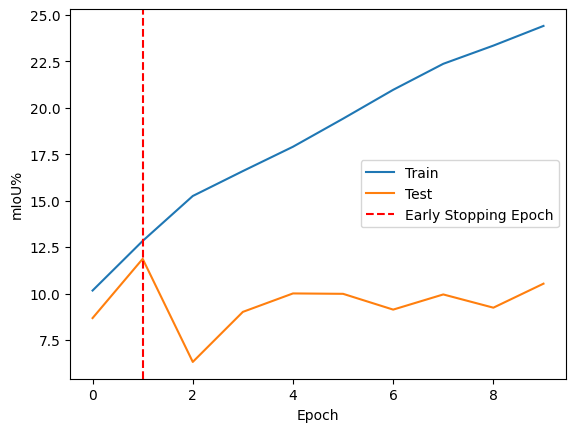

In [10]:
#Testing Domain Shift problem in semantic segmentation

#Set up the model with the pretrained weights
BiSeNet_model = BiSeNet(num_classes=19, context_path='resnet18').to(device)

#Set up the loss function and the optimizer for BiSeNet
BiSeNet_criterion = torch.nn.CrossEntropyLoss(ignore_index=255)
BiSeNet_optimizer = torch.optim.SGD(BiSeNet_model.parameters(), lr=2.5e-2, momentum=0.9, weight_decay=1e-4)

#Train the model
all_train_miou, all_test_miou, best_epoch = train_model(BiSeNet_model, BiSeNet_criterion, BiSeNet_optimizer,
            gta5_dataloader, cityscapes_test_dataloader, class_names, device, n_epochs,
            lr_schedule=True, model_name='BiSeNet')

plot_miou_over_epochs(all_train_miou, all_test_miou, best_epoch)